# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 32

**Author 1 (sciper):** Alexia Dormann (301997)
**Author 2 (sciper):** Valgerdur Jónsdóttir (351819)  
**Author 3 (sciper):** Mariia Eremina (342236)   

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [2]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [3]:
import platform
print(platform.system())
if platform.system() == "Darwin":
    %pip install torch==1.8.1 torchvision==0.9.1
else:
    %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Darwin
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tarfile
import os
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [5]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

First, we start by defining the following functions: `compute_mahalanobis_distance`, ```classifier_min_mahalanobis``` and ```compute_mean_cov_train```. The first function computes the Mahalanobis distance between a test point and a set of training points. The second function classifies a test point based on the minimum Mahalanobis distance. The last function computes the statistics needed for the Mahalanobis distance computation.

In [50]:
### Task 1
from sklearn.covariance import LedoitWolf
from numpy.linalg import inv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_mahalanobis_distance(x, mean_train, cov_train):
    '''
    Compute the mahalanobis distance between a test point and a set of training points
    :param x: test point
    :param mean_train: mean of the training set
    :param cov_train: the inverse covariance matrix of the training set
    :return: mahalanobis distance
    '''
    distance = torch.matmul((x - mean_train).view(1,-1), torch.from_numpy(cov_train))  
    distance = torch.matmul(distance, (x - mean_train).view(-1,1)).item()
    distance = np.sqrt(distance)

    return distance

def classifier_min_mahalanobis(x, mean_train, cov_train):
    '''
    Classify a test point based on the minimum Mahalanobis distance
    :param x: test point
    :param mean_train: mean of the training set
    :param cov_train: the inverse covariance matrix of the training set
    :return: minimum Mahalanobis distance and the label of the closest training point
    '''
    # compute mahalanobis distance to each group type
    distances = {}
    for i, mean in enumerate(mean_train):
        distances[i] = compute_mahalanobis_distance(x, mean, cov_train[i])
    distances = pd.Series(distances)
    # find min dist and group closest to test point
    min_dist = distances.min()
    label_x = distances.idxmin()
    
    return min_dist, label_x

def compute_mean_cov_train(train, train_labels, tissue_type):
    '''
    Compute the statistics on the training set for each tissue type,
     i.e., the mean and the inverse covariance for each tissue type in the training dataset.
    :param train: train features
    :param train_labels: train labels
    :param tissue_type: tissue types to compute mean and covariance for
    :return: mean and the inverse covariance for each tissue type
    '''
    mean, cov = [], []
    for tissue in tissue_type:
        idx_tissue = np.where(train_labels == tissue)
        mean.append(torch.mean(train[idx_tissue], dim=0))
        cov.append(inv(LedoitWolf().fit(train[idx_tissue]).covariance_))
    return mean, cov

Now, we apply these functions to our dataset and compute the minimum Mahalanobis distance for each test point to obtain a prediction of its label.

In [51]:
# compute mean and cov for each tissue type
mean_train, cov_train = compute_mean_cov_train(train_features, train_labels, label_to_classname.keys())

# predict for each test datapoint
pred = [classifier_min_mahalanobis(x, mean_train, cov_train) for x in test_features]

min_dist =[x[0] for x in pred]
pred = [x[1] for x in pred]

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [52]:
### Task 2
from sklearn.metrics import confusion_matrix

# compute accuracy for each class
matrix = confusion_matrix(test_labels, pred)
TUMOR_accuracy = (matrix.diagonal()*100/matrix.sum(axis=1))[0]
STROMA_accuracy = (matrix.diagonal()*100/matrix.sum(axis=1))[1]
print(f"The accuracy of the prediction using the Mahalanobis distance for TUMOR is: {TUMOR_accuracy} %")
print(f"The accuracy of the prediction using the Mahalanobis distance for STROMA is: {round(STROMA_accuracy,3)} %")

overall_accuracy = np.sum(pred == test_labels) / len(test_labels)
print("The overall accuracy of our prediction is therefore: {:.3f}%".format(overall_accuracy * 100))


The accuracy of the prediction using the Mahalanobis distance for TUMOR is: 100.0 %
The accuracy of the prediction using the Mahalanobis distance for STROMA is: 95.699 %
The overall accuracy of our prediction is therefore: 97.849%


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [53]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:**
If we assume that the Mahalanobis distance is a good estimate of how similar two points are, then, if a point has a very large distance from all the datapoints in the training set it means that it is not very similar to any of the point in the training dataset. Therefore, we can conclude that it most likely doesn't belong to any of the tissue type in the training set.

To summarize, the minimum Mahalanobis distance is a good OoD-ness score for several reasons:

1. Mahalanobis distance is a measure of the distance between a point and a distribution. It takes into account the covariance of the data, which makes it more effective than Euclidean distance in high-dimensional spaces, where the correlation between features can lead to misleading distances.
2. Minimum Mahalanobis distance is a measure of how far a point is from the center of its nearest class, normalized by the covariance of that class. Since it is based on class-specific statistics, it is sensitive to the underlying structure of the data, and can thus effectively discriminate between in-distribution and out-of-distribution samples.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [54]:
### Task 2
# compute mahalanobis distance to each tissue type
min_distances = [classifier_min_mahalanobis(test, mean_train, cov_train)[0] for test in test_features_w_ood]
min_distances[-10:] # distance for last 10 example

[73.65677038954905,
 82.46885065359527,
 79.58228347911361,
 82.35573620068155,
 82.14359865979362,
 78.91180982887637,
 83.17028547936306,
 81.55446260686014,
 76.99338889537043,
 78.06130215754314]

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

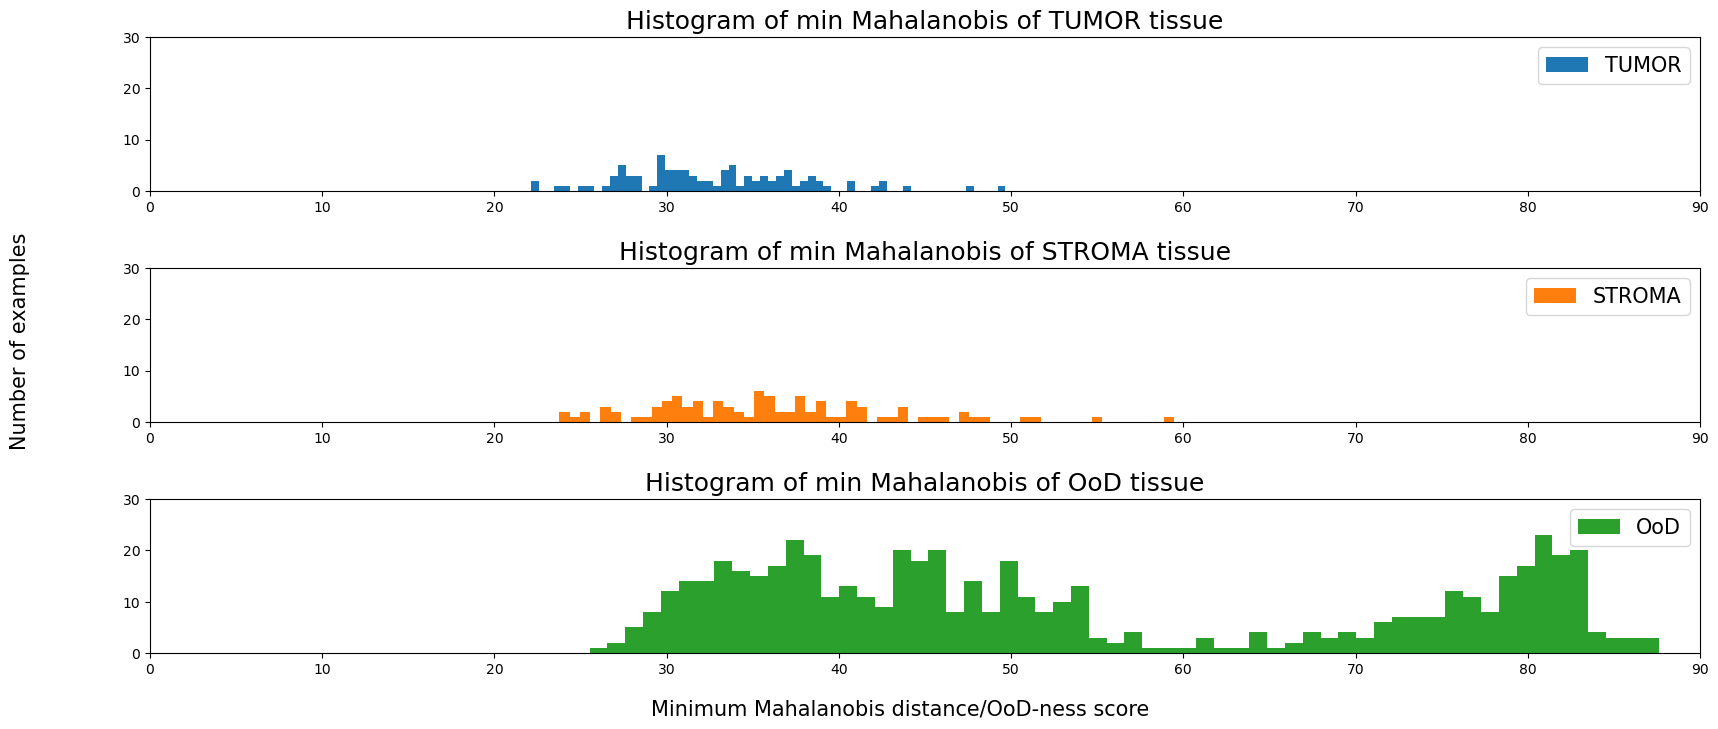

In [55]:
### Task 3
# compute distances for each tissue type
distances_tissues = {}
for tissue in label_to_classname_w_ood.keys():
    distances_tissues[label_to_classname_w_ood[tissue]] = np.array(min_distances)[test_labels_w_ood == tissue]

# plot the histograms
fig, axes = plt.subplots(3,1, figsize=(20, 8))
plt.rcParams.update({'font.size': 15})
plt.subplots_adjust(hspace=0.5)
for i, tissue in enumerate(label_to_classname_w_ood.values()):
    axes[i].hist(distances_tissues[tissue], bins = 60)
    axes[i].set_title('Histogram of min Mahalanobis of ' + tissue + ' tissue')
    axes[i].set_xlim(0,90)
    axes[i].set_ylim(0, 30)
    for patch in axes[i].patches:
        patch.set_facecolor('C' + str(i))
    axes[i].legend([tissue])

fig.text(0.5, 0.04, 'Minimum Mahalanobis distance/OoD-ness score', ha='center', va='center')
fig.text(0.06, 0.5, 'Number of examples', ha='center', va='center', rotation='vertical')
plt.show()

**Observations:** From this, we observe two quite similar histograms, i.e., the histograms for the TUMOR and the STROMA tissues are very similar, but the histogram for the OoD-samples is different, as it shows that many of the OoD-samples have much higher minimum Mahalanobis distance than the ID-samples. Therefore, we can use the Mahalanobis distance as an OoD-ness score to easily detect OoD-samples. Doing so, we can filter out the samples from the dataset that have a high minimum Mahalanobis distance to obtain a more In-Distribution dataset.

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

To find the required threshold, we can compute the 5th percentile of the OoD examples. The 5th percentile is the value that  separates the lowest 5% of the data from the highest 95% of the data. That it, it is the value below which 5% of the observations fall. Therefore, if we filter out all the samples that have a minimum Mahalanobis distance higher than the 5th percentile, we will filter out 95% of the OoD examples.

In [56]:
### Task 4
thres = np.percentile(distances_tissues["OoD"], 5)
print("Threshold: {:.2f}".format(thres))

Threshold: 30.77


In [62]:
# filter out OoD examples
# Get idx of sample with min dist lower than threshold -> keep
idx_OoD = np.argwhere([dist < thres for dist in min_distances])
test_filtered = np.squeeze(np.array(test_features_w_ood[idx_OoD,:])); test_filtered_labels = np.squeeze(np.array(test_labels_w_ood[idx_OoD]))

# compute percentage of filtered samples for each tissue type
print('Percentage of examples filtered out for:')
for tissue_type in label_to_classname_w_ood.keys():
    perc = (test_filtered_labels[np.where(test_filtered_labels == tissue_type)].shape[0]/test_labels_w_ood[np.where(test_labels_w_ood == tissue_type)].shape[0])* 100
    print(label_to_classname_w_ood[tissue_type], ': ', round(100 - perc,2),'%')

Percentage of examples filtered out for:
TUMOR :  61.29 %
STROMA :  74.19 %
OoD :  94.98 %


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [67]:
### Task 5
# get filtered idx
idx_OoD = np.argwhere([dist > thres for dist in min_distances])

# predict using min distance
pred = np.array([classifier_min_mahalanobis(x, mean_train, cov_train)[1] for x in test_features_w_ood])

# assign -1 pred to filtered out example
pred[idx_OoD] = -1

# compute accuracy for each class
matrix = confusion_matrix(test_labels_w_ood, pred)
print('The average class-wise accuracy of the prediction using the Mahalanobis distance for each tissue is:')

accuracy_tumor = (matrix.diagonal()*100/matrix.sum(axis=1))[1]
accuracy_stroma = (matrix.diagonal()*100/matrix.sum(axis=1))[2]
accuracy_OoD = (matrix.diagonal()*100/matrix.sum(axis=1))[0]
print(f'TUMOR - {(accuracy_tumor):.2f} %')
print(f'STROMA - {accuracy_stroma:.2f} %')
print(f'OoD - {accuracy_OoD:.2f} %')

The average class-wise accuracy of the prediction using the Mahalanobis distance for each tissue is:
TUMOR - 38.71 %
STROMA - 25.81 %
OoD - 94.98 %


From this, we see that the accuracy for the TUMOR and STROMA tissues is very low, while the accuracy for the OoD-samples is quite high. Therefore, this method is not satisfactory. As the main goal is to detect the TUMOR and STROMA tissues and not the OoD-samples, it is not satisfactory to get such low accuracy of predicting those samples. One reason for this is that we filtered out many of the samples of these tissues (TUMOR and STROMA). Therefore, we would need to find a better method of outlier detection.

### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

First, we start with finding a suitable k. To do so, we will use the k-NN classifier from scikit-learn. We will try different values of k and compute the accuracy of the classifier for each value of k. Then, we will plot the accuracy as a function of k to find the best value of k.

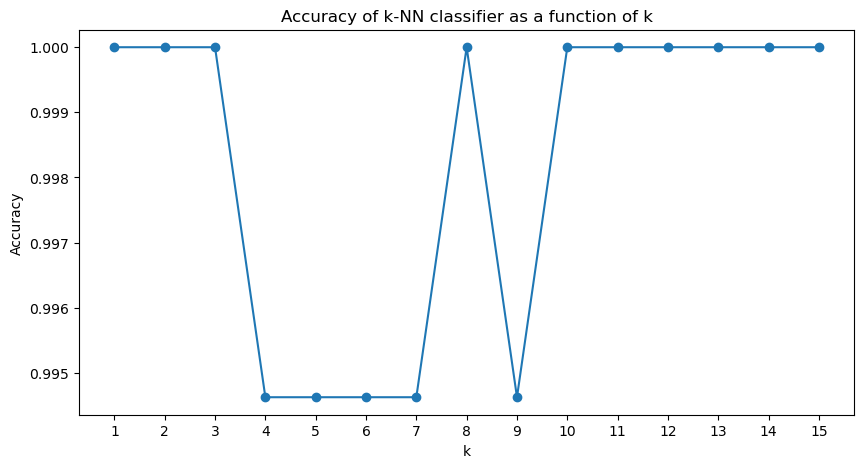

In [15]:
### Task 1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# find suitable k
n_neigh = np.arange(1,16)
score = []
for k in n_neigh:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_features, train_labels)
    
    pred = neigh.predict(test_features)
    score.append(accuracy_score(test_labels, pred))

plt.figure(figsize=(10,5))
plt.plot(score, 'o-')
plt.title('Accuracy of k-NN classifier as a function of k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(np.arange(len(n_neigh)), n_neigh)
plt.show()

From the plot above, we see that the accuracy is very good for k=1. Therefore, we will use k=1 for the k-NN classifier.

In [17]:
# Exmaple with k=1

# create a k-NN classifier with k=1
knn = KNeighborsClassifier(n_neighbors=1)

# train the classifier on the training data
knn.fit(train_features, train_labels)

# make predictions on the test data
test_pred_labels = knn.predict(test_features)

# compute the accuracy of the predictions
accuracy = (test_pred_labels == test_labels).mean()
print(f"Accuracy of k-NN classifier: {accuracy:.3f}")

Accuracy of k-NN classifier: 1.000


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

First, we will compute the OoD-ness score using the k-NN distance, that is, we use the distance of a point to the k-th nearest neighbor as a measure of the point's OOD-ness. The intuition behind this is that points that are far away from the k-th nearest neighbors of the training set are likely to be OoD. Then, we will find a threshold on the OoD-ness score such that 95% of the OoD examples are filtered out.

In [46]:
### Task 2
# Compute OoD-ness score using k-NN distance
k = 1
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_features, train_labels)
ood_scores = knn.kneighbors(test_features_w_ood, return_distance=True)[0][:, -1]

In [58]:
# we find threshold to filter out 95% of OoD examples in the same way as in Task 1.2 (4)
knn_tissues = {}
for tissue in label_to_classname_w_ood.keys():
    knn_tissues[label_to_classname_w_ood[tissue]] = np.array(ood_scores)[test_labels_w_ood == tissue]

ood_threshold = np.percentile(knn_tissues["OoD"], 5)
print(f'Threshold to filter out 95% of OoD examples: {ood_threshold:.3f}')

Threshold to filter out 95% of OoD examples: 40.767


Finally, we will assign prediction -1 to the filtered out examples and compute the average class-wise accuracy of our prediction with test labels.

In [70]:
# Compute the number of TUMOR and STROMA samples filtered out
tumor_filtered_out = sum((test_labels_w_ood == 0) & (ood_scores >= ood_threshold))
stroma_filtered_out = sum((test_labels_w_ood == 1) & (ood_scores >= ood_threshold))
Ood_filtered_out = sum((test_labels_w_ood == -1) & (ood_scores >= ood_threshold))

# Assign prediction -1 to filtered out examples
pred_labels = np.where(ood_scores >= ood_threshold, -1, knn.predict(test_features_w_ood))

# Compute class-wise accuracy by class
tumor_acc = np.mean((pred_labels[test_labels_w_ood == 0] == 0))
stroma_acc = np.mean((pred_labels[test_labels_w_ood == 1] == 1))
Ood_acc = np.mean((pred_labels[test_labels_w_ood == -1] == -1))
# Compute class-wise accuracy
class_wise_accuracy = []
for i in range(3):
    idx = (test_labels_w_ood == i) & (pred_labels != -1)
    if sum(idx) == 0:
        class_wise_accuracy.append(0)
    else:
        class_wise_accuracy.append(sum(test_labels_w_ood[idx] == pred_labels[idx]) / sum(idx))
average_accuracy = sum(class_wise_accuracy) / 3

print("Number of TUMOR samples filtered out:",tumor_filtered_out)
print("Number of STROMA samples filtered out:",stroma_filtered_out)
print("Number of OoD samples filtered out:",Ood_filtered_out)

Number of TUMOR samples filtered out: 65
Number of STROMA samples filtered out: 44
Number of OoD samples filtered out: 530


In [71]:
# compute the percentage of filtered out samples
tumor_filtered_out_percentage = tumor_filtered_out / sum(test_labels_w_ood == 0)
stroma_filtered_out_percentage = stroma_filtered_out / sum(test_labels_w_ood == 1)
Ood_filtered_out_percentage = Ood_filtered_out / sum(test_labels_w_ood == -1)

print(f'Percentage of TUMOR samples filtered out: {tumor_filtered_out_percentage*100:.3f}%')
print(f'Percentage of STROMA samples filtered out: {stroma_filtered_out_percentage*100:.3f}%')
print(f'Percentage of OoD samples filtered out: {Ood_filtered_out_percentage*100:.3f}%')

Percentage of TUMOR samples filtered out: 69.892%
Percentage of STROMA samples filtered out: 47.312%
Percentage of OoD samples filtered out: 94.982%


In [72]:
print("Overall accuracy:",round(average_accuracy*100,3),"%")
print("The average class-wise accuracy is:")
print("Tumor -",round(tumor_acc*100,3),"%")
print("Stroma -", round(stroma_acc*100,3),"%")
print("OoD -",round(Ood_acc*100,3),"%")

Overall accuracy: 66.667 %
The average class-wise accuracy is:
Tumor - 30.108 %
Stroma - 52.688 %
OoD - 94.982 %


**Task 3 (1 point)** Is k-NN better than Mahalanobis distance? Make an hypothesis for the reasons.

**Answer:** K-nearest neighbors (k-NN) and Mahalanobis distance are both distance-based algorithms commonly used for anomaly detection and OoD detection. However, there are some reasons why k-NN may perform better than Mahalanobis distance in certain situations:

1. Non-parametric: k-NN is a non-parametric method, which means that it doesn't make any assumptions about the underlying distribution of the data. In contrast, Mahalanobis distance assumes that the data follows a multivariate normal distribution. If this assumption is violated, Mahalanobis distance can produce poor results.
2. Robustness to outliers: k-NN is more robust to outliers than Mahalanobis distance. In k-NN, the distance to the k nearest neighbors is used to determine the OoD-ness score. Outliers are less likely to be among the k nearest neighbors, and therefore have less impact on the OoD-ness score. In contrast, Mahalanobis distance is sensitive to outliers, which can significantly affect the distance calculation.
3. Adaptive to the local data structure: k-NN is adaptive to the local data structure, which means that it can capture the local structure of the data and identify anomalies that are specific to a particular region of the feature space. In contrast, Mahalanobis distance is not adaptive to the local data structure and assumes that the covariance matrix is constant across the entire feature space.

Overall, the performance of k-NN and Mahalanobis distance depends on the specific characteristics of the data and the application. In some cases, Mahalanobis distance may outperform k-NN, especially when the data is well-modeled by a multivariate normal distribution. However, in many cases, k-NN is a better choice due to its non-parametric nature, robustness to outliers, and adaptivity to the local data structure.

In this case, we notice that the accuracy for STROMA examples increased with using k-nn instead of Mahalanobis distance.

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:** The approach presented in this exercise can be a useful step towards computing TUMOR/STROMA ratio automatically, but it may not be sufficient on its own. One limitation is that the approach relies on having a labeled training dataset, which may not be available or feasible to obtain in all cases. Additionally, the k-NN distance based OoD-ness score used in the approach may not be robust to changes in the distribution of the data.

To improve the approach, here are two possible ideas:

1. Semi-supervised learning: Instead of relying solely on a labeled training dataset, we can also make use of unlabeled data to improve the model's performance. This can be done through semi-supervised learning techniques, such as self-training or co-training, which leverage the information in unlabeled data to improve the accuracy of a classifier.
2. Transfer learning: Instead of starting from scratch with a new dataset, we can leverage pre-trained models on similar tasks to improve the accuracy of our model. For example, we can use a pre-trained image classification model and fine-tune it on our TUMOR/STROMA dataset. This can help reduce the amount of labeled data needed to achieve good performance.

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [73]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [74]:
# Load the features
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'

In [75]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the data 
        import torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        return self.labels.size()[0]
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        embedding = self.features[index,:]
        label = self.labels[index]
        path = self.paths[index]
        
        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [76]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, 'train')
val_dataset = Sipakmed(features_path, 'val')
test_dataset = Sipakmed(features_path, 'test')

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [77]:
# Instantiate the data loaders
from torch.utils.data import DataLoader

# Set batch size
batch_size = 32

# Instantiate the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

Get to know your data. Plot a few example images for each class of your dataset.

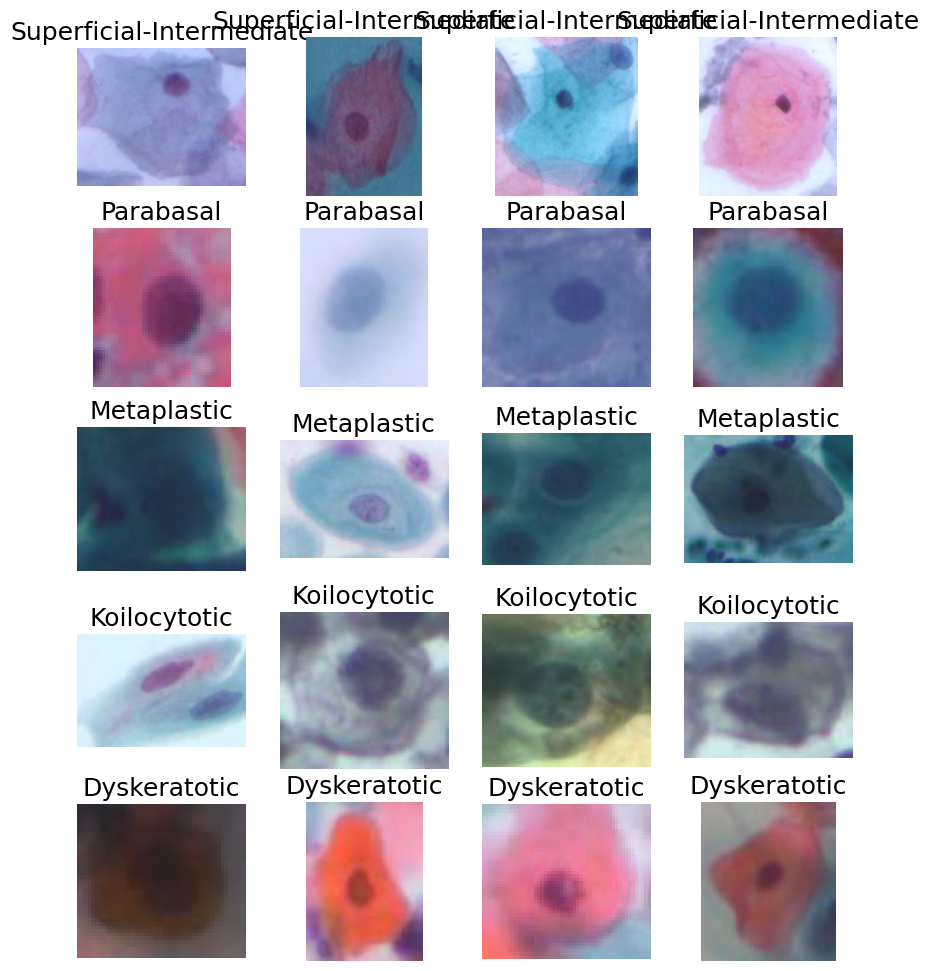

In [81]:
# Define the class names
class_names = ['Superficial-Intermediate', 'Parabasal', 'Metaplastic', 'Koilocytotic', 'Dyskeratotic']

# Plot a few examples for each class
fig, axs = plt.subplots(5, 4, figsize=(10, 12))
for i, class_name in enumerate(class_names):
    # Find the indices of the samples that belong to the current class
    indices = [j for j, (_, label, _) in enumerate(train_loader.dataset) if label == i]

    # Plot the first four samples
    for j in range(4):
        if j < len(indices):
            # Load the image from the path
            path = train_loader.dataset[indices[j]][2]
            img = plt.imread("../data/lab-03-data/part2/"+path)

            # Plot the image
            axs[i, j].imshow(img)
            axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

plt.show()

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [82]:
# Implement the model
embedding_dim = train_dataset.features.shape[1]
hidden_dim = 150
output_dim = len(train_dataset.label_dict)
class CellsImgClassifier(torch.nn.Module):
    def __init__(self, emb_dim, hidden_dim, output_dim):
        super().__init__()

        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.activation_func = torch.tanh
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
     
    def forward(self, input):
        layer1 = self.activation_func(self.linear1(input) )
        logits = self.log_softmax(self.linear2(layer1))
        
        return logits
    
model = CellsImgClassifier(embedding_dim, hidden_dim, output_dim)

The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [83]:
# Set the optimizer
import torch.optim as optim
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [84]:
# Set the loss
criterion = torch.nn.CrossEntropyLoss()

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [85]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    total = len(labels)
    return correct / total

Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [86]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    model.train()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths 
        input, label, path = batch
        
        # Feed the embeddings to the model
        out = model(input)

        # Compute cross entropy loss
        loss = criterion(out, label)
        
        # Reset the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        # Store the outputs, labels and loss
        full_outputs.append(out); full_labels.append(label); losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    
    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [87]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in evaluation mode
    model.eval()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        embeddings, labels, paths = batch
        
        # Feed the embeddings to the model
        outputs = model(embeddings)
        
        # Compute cross entropy loss
        loss = criterion(outputs, labels)
        
        # Store the outputs, labels and loss
        full_outputs.append(outputs)
        full_labels.append(labels)
        full_paths.append(paths)
        losses.append(loss)
    
    # Concatenate tensors and convert to cpu
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [89]:
# Main loop with learning process
epochs = 10
best_acc = 0
model_savepath = '../data'

for epoch in range(epochs):
    # Train
    train_acc, train_outputs, train_labels, train_loss = train(model, optimizer, criterion, train_loader)

    # Evaluate on validation set
    val_acc, val_outputs, val_labels, val_loss, val_paths = validate(model, criterion, val_loader)

    # Save the model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_savepath + '/best_model.pth')
    
    # Print results
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss:.4f} - Training accuracy: {train_acc:.4f} - Validation loss: {val_loss:.4f} - Validation accuracy: {val_acc:.4f}")


Epoch 1/10 - Training loss: 0.1286 - Training accuracy: 0.9570 - Validation loss: 0.1856 - Validation accuracy: 0.9298
Epoch 2/10 - Training loss: 0.0717 - Training accuracy: 0.9787 - Validation loss: 0.1643 - Validation accuracy: 0.9417
Epoch 3/10 - Training loss: 0.0419 - Training accuracy: 0.9896 - Validation loss: 0.1628 - Validation accuracy: 0.9466
Epoch 4/10 - Training loss: 0.0237 - Training accuracy: 0.9955 - Validation loss: 0.1870 - Validation accuracy: 0.9368
Epoch 5/10 - Training loss: 0.0150 - Training accuracy: 0.9980 - Validation loss: 0.1859 - Validation accuracy: 0.9417
Epoch 6/10 - Training loss: 0.0083 - Training accuracy: 1.0000 - Validation loss: 0.1819 - Validation accuracy: 0.9407
Epoch 7/10 - Training loss: 0.0056 - Training accuracy: 1.0000 - Validation loss: 0.1875 - Validation accuracy: 0.9417
Epoch 8/10 - Training loss: 0.0042 - Training accuracy: 1.0000 - Validation loss: 0.1924 - Validation accuracy: 0.9447
Epoch 9/10 - Training loss: 0.0031 - Training ac

In [90]:
print("Best validation accuracy during train model : ",round(best_acc*100,3),"%")

Best validation accuracy during train model :  94.664 %


### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [92]:
# Re-load the best model
model = CellsImgClassifier(embedding_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load(model_savepath+'/best_model.pth'))

# Evaluate on test set
test_acc, test_outputs, test_labels, test_loss, test_paths = validate(model, criterion, test_loader)
print('Test accuracy:', round(test_acc*100,3),"%")

Test accuracy: 94.384 %


A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

In [93]:
# Display the confusion matrix

# Get the predictions and labels for the test set
test_preds = []
test_labels = []
for batch in test_loader:
    # Get the embeddings, labels and paths
    embeddings, labels, _ = batch

    # Feed the embeddings to the model
    outputs = model(embeddings)

    # Get the predictions
    _, preds = torch.max(outputs, dim=1)

    # Store the predictions and labels
    test_preds.extend(preds.tolist())
    test_labels.extend(labels.tolist())

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

print(cm)

[[208   0   0   0   0]
 [  0 193   1   0   3]
 [  0   2 185   7   5]
 [  2   1   8 183  13]
 [  0   1   2  12 189]]


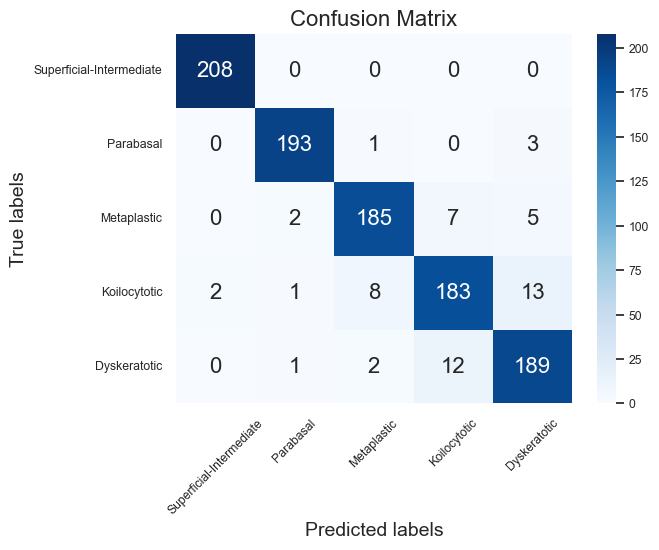

In [98]:
import seaborn as sns

labels = ['Superficial-Intermediate', 'Parabasal', 'Metaplastic', 'Koilocytotic', 'Dyskeratotic']
# Create a heatmap of the confusion matrix
ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16},xticklabels=labels, yticklabels=labels)
# Rotate the x-axis tick labels by 45 degrees
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Rotate the y-axis tick labels by 45 degrees
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
# Set the axis labels
plt.xlabel("Predicted labels", fontsize=14)
plt.ylabel("True labels", fontsize=14)

# Set the title
plt.title("Confusion Matrix", fontsize=16)
plt.show()

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

We will plot 10 of the misclassified samples:

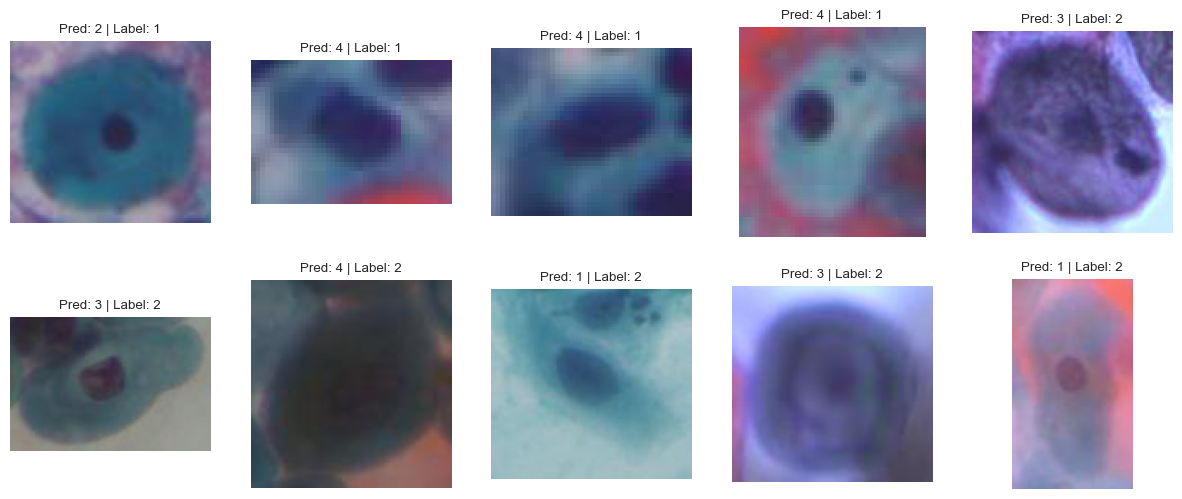

In [100]:
# Find the misclassified samples
test_acc, test_outputs, test_labels, test_loss, test_paths = validate(model, criterion, test_loader)
pred_labels = torch.argmax(test_outputs, dim=1)
misclassified_mask = pred_labels != test_labels

#Plot the misclassified samples, get 10 examples
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10): 
    # Get the image
    img = Image.open("../data/lab-03-data/part2/"+test_paths[misclassified_mask][i])
    # Plot the image
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f'Pred: {pred_labels[misclassified_mask][i]} | Label: {test_labels[misclassified_mask][i]}')
    axs[i//5, i%5].axis('off')